Predicting: 100%|██████████| 351/351 [19:28<00:00,  3.33s/it]


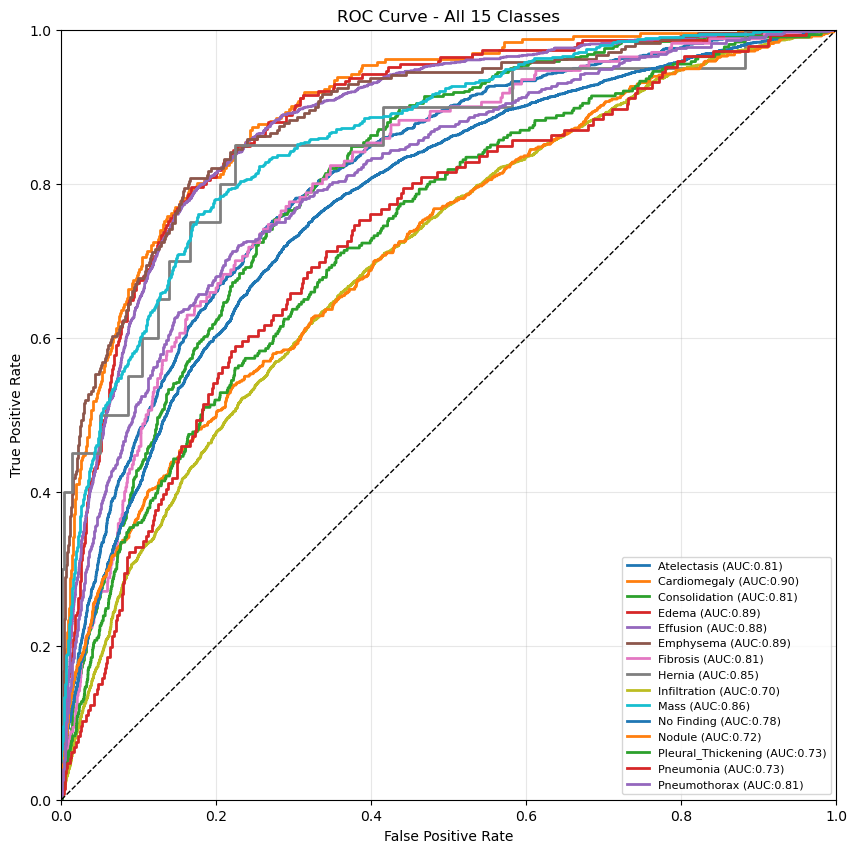

✔ ROC curve saved as ROC_All_Classes.png


In [ ]:
#ِAUC for Predict random Images "تجربةالموديل ع صور حقيقة لم يتمرن عليها سابقا"

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pickle
import numpy as np
import os
from tqdm import tqdm
import pandas as pd

# ----------------------------
# FIX for PyTorch 2.6 checkpoint loading
# ----------------------------
from torch.serialization import add_safe_globals
import torchvision.models.resnet as resnet
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.linear import Linear
from torch.nn.modules.batchnorm import BatchNorm2d

add_safe_globals([resnet.ResNet, resnet.Bottleneck, Conv2d, Linear, BatchNorm2d])

# ----------------------------
# CONFIG
# ----------------------------
CKPT_PATH = "models/stage3_0007_07.pth"
CLASSES_PICKLE = "pickles/disease_classes.pickle"
IMG_DIR = "D:/CLS PROJECT/CXR8/images"
CSV_PATH = "D:/CLS PROJECT/CXR8/Data_Entry_2017.csv"

BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Load classes
# ----------------------------
with open(CLASSES_PICKLE, "rb") as f:
    class_names = pickle.load(f)
num_classes = len(class_names)

# ----------------------------
# Preprocessing
# ----------------------------
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# ----------------------------
# Dataset
# ----------------------------
class XRayDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]

        img_path = os.path.join(self.img_dir, row["Image Index"])
        img = Image.open(img_path).convert("RGB")
        img = transform(img)

        labels = np.zeros(num_classes, dtype=np.float32)
        findings = row["Finding Labels"].split("|")

        for f in findings:
            if f in class_names:
                labels[class_names.index(f)] = 1.0

        return img, labels

# ----------------------------
# Load CSV
# ----------------------------
df = pd.read_csv(CSV_PATH)

# validation sample 10%
val_df = df.sample(frac=0.1, random_state=42)

dataset = XRayDataset(val_df, IMG_DIR)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# Load model with fix
# ----------------------------
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=False)

# checkpoint contains full model object
if "model" in ckpt:
    try:
        model.load_state_dict(ckpt["model"])
    except:
        model = ckpt["model"]
else:
    model.load_state_dict(ckpt)

model = model.to(DEVICE)
model.eval()

# ----------------------------
# Collect predictions
# ----------------------------
y_true_all = []
y_probs_all = []

with torch.no_grad():
    for imgs, labels in tqdm(loader, desc="Predicting"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs).cpu().numpy()

        y_true_all.append(labels)
        y_probs_all.append(probs)

y_true = np.concatenate(y_true_all)
y_probs = np.concatenate(y_probs_all)

# ----------------------------
# Plot ROC
# ----------------------------
plt.figure(figsize=(10, 10))

for i in range(num_classes):
    try:
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC:{roc_auc:.2f})")
    except:
        print(f"⚠ كلاس {class_names[i]} لا يمكن حساب ROC له (قد يكون imbalanced جداً)")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All 15 Classes")
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)

plt.savefig("ROC_All_Classes.png", dpi=400)
plt.show()

print("✔ ROC curve saved as ROC_All_Classes.png")


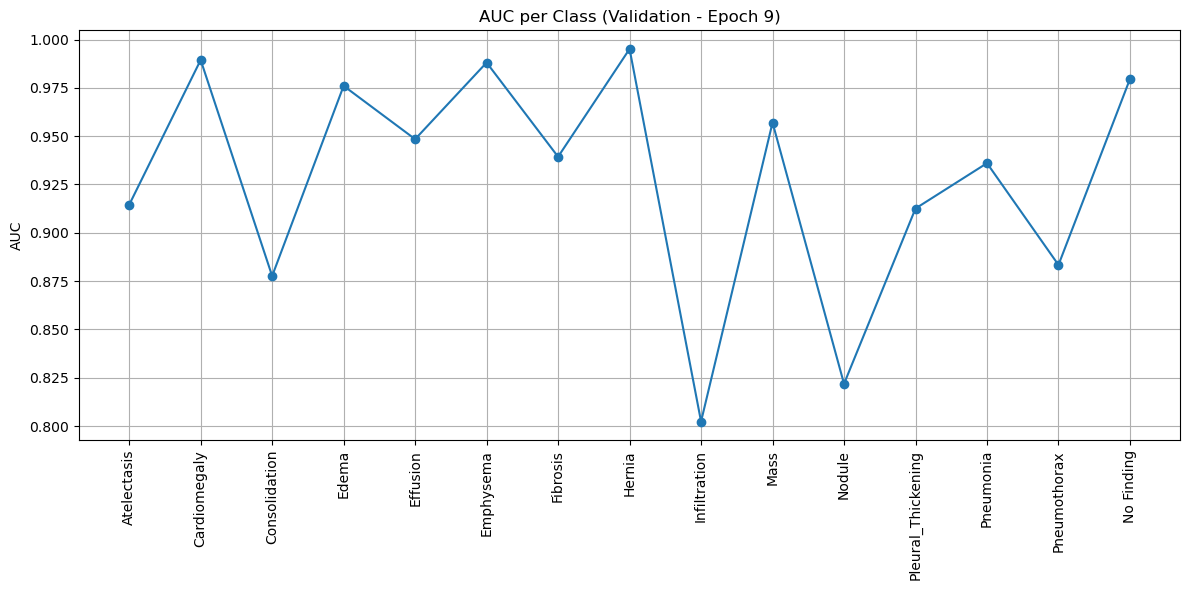

In [ ]:
#Line plot from output result in stage 3- epoch 9 "Validation"

import matplotlib.pyplot as plt

classes = [
    'Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
    'Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule',
    'Pleural_Thickening','Pneumonia','Pneumothorax','No Finding'
]

auc_values = [
    0.9144921063785953,
    0.9894360239476814,
    0.8776348716004746,
    0.9760251418384046,
    0.9484479709450696,
    0.9880848238063726,
    0.9393352208437586,
    0.9951287141531623,
    0.8023347326352707,
    0.9570318341975568,
    0.8218457354317107,
    0.9125686855856266,
    0.9360255442074624,
    0.8833686832168393,
    0.9795806086519114
]

plt.figure(figsize=(12,6))
plt.plot(classes, auc_values, marker='o')
plt.xticks(rotation=90)
plt.ylabel("AUC")
plt.title("AUC per Class (Validation - Epoch 9)")
plt.grid(True)
plt.tight_layout()
plt.show()


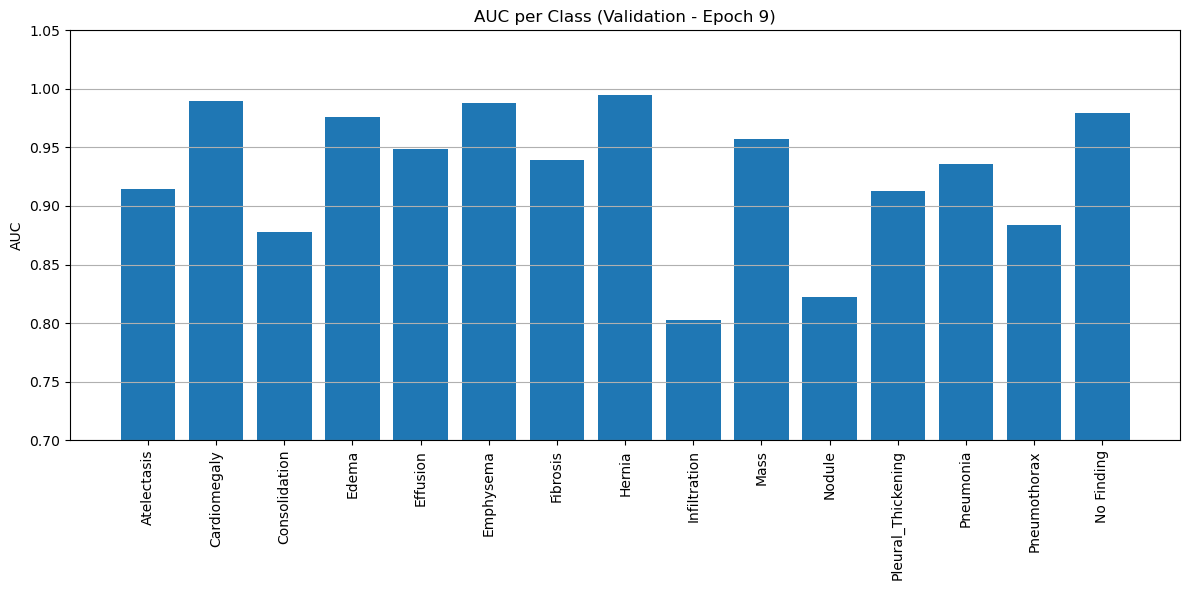

In [ ]:
#Bar Chart from output result in stage 3- epoch 9 "Validation"
import matplotlib.pyplot as plt

classes = [
    'Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
    'Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule',
    'Pleural_Thickening','Pneumonia','Pneumothorax','No Finding'
]

auc_values = [
    0.9144921063785953,
    0.9894360239476814,
    0.8776348716004746,
    0.9760251418384046,
    0.9484479709450696,
    0.9880848238063726,
    0.9393352208437586,
    0.9951287141531623,
    0.8023347326352707,
    0.9570318341975568,
    0.8218457354317107,
    0.9125686855856266,
    0.9360255442074624,
    0.8833686832168393,
    0.9795806086519114
]

plt.figure(figsize=(12,6))
plt.bar(classes, auc_values)
plt.xticks(rotation=90)
plt.ylabel("AUC")
plt.ylim(0.7, 1.05)
plt.title("AUC per Class (Validation - Epoch 9)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
